## Importing libraries

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import numpy as np
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import os 

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import os 

In [3]:
import numpy as np # linear algebra
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score 
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Flatten,Dense
from tensorflow.keras.applications import resnet50

## Loading the dataset

In [4]:
# Add class name prefix to each path based on class name include in filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]
    

IMAGES_DIR = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification/'
    
train_file = '/kaggle/input/garbage-classification/one-indexed-files-notrash_train.txt'
val_file   = '/kaggle/input/garbage-classification/one-indexed-files-notrash_val.txt'
test_file  = '/kaggle/input/garbage-classification/one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['path', 'label'])

df_train = add_class_name_prefix(df_train, 'path')
df_valid = add_class_name_prefix(df_valid, 'path')
df_test  = add_class_name_prefix(df_test,  'path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')

Found 1768 training, 328 validation and 328 samples.


In [57]:
batch_size=64
image_size=128

## Image Preprocessing

In [58]:
# ImageDataGenerator: For data preprocessing
# flow_from_dataframe: Takes the Pandas DataFrame and the path to a directory and generates batches of augmented/normalized data

gen = ImageDataGenerator(rescale=1./255)    # rescaling the images between 0 and 1

train_ds = gen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    target_size=(image_size,image_size)
)
val_ds = gen.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    target_size=(image_size,image_size)
)

test_ds = gen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
    target_size=(image_size,image_size)
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


In [29]:
test_ds

In [84]:
data_augmentation=tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                      layers.experimental.preprocessing.RandomRotation(10),tf.keras.layers.RandomZoom(.4)])

## Model

In [85]:
def train_model_feature_extraction(lr,epochs):
    pretrained_model= tf.keras.applications.VGG19(include_top=False,
                   input_shape=(image_size,image_size,3),
                   #pooling='avg',
                   weights='imagenet')
    print("Number of layers in the base model: ", len(pretrained_model.layers))

    
    pretrained_model.summary()
    VGG19_model_frozen = Sequential([data_augmentation])
    pretrained_model.trainable = False
    #for layer in pretrained_model.layers[:12]:
        #layer.trainable = False


    #for layer in pretrained_model.layers[:-1]: # go through until last layer
        #resnet_model.add(layer)


    #resnet_model.add(tf.keras.layers.BatchNormalization(renorm=True))
    VGG19_model_frozen.add(pretrained_model)
    #resnet_model.add(tf.keras.layers.BatchNormalization())
    VGG19_model_frozen.add(Flatten())

    prediction_layer = tf.keras.layers.Dense(6, activation='softmax')
    VGG19_model_frozen.add(prediction_layer)

    #model.compile(optimizer='adam', loss='categorical_crossentropy')
    for i, layer in enumerate(pretrained_model.layers):
            print(i, layer.name, "-", layer.trainable)
            
    opt = Adam(learning_rate=lr)
    VGG19_model_frozen.compile(optimizer=opt,loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
    history=VGG19_model_frozen.fit(train_ds,epochs=epochs,batch_size=batch_size,verbose=1,validation_data=val_ds)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,5.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    scores=VGG19_model_frozen.evaluate(test_ds)
    print(scores)
    

Number of layers in the base model:  22
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooli

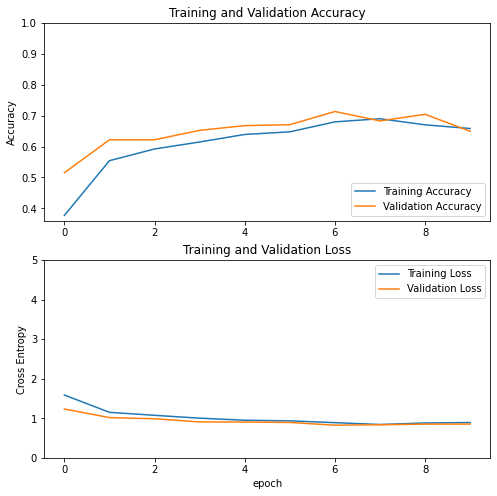

6/6 [==============================] - 1s 170ms/step - loss: 0.8527 - accuracy: 0.6494
[0.8526649475097656, 0.6493902206420898]


In [87]:
train_model_feature_extraction(0.001,10)

In [80]:
def fine_tuning (lr,epochs):
    pretrained_model= tf.keras.applications.VGG19(include_top=False,
                   input_shape=(image_size,image_size,3),
                   #pooling='avg',
                   weights='imagenet')
    print("Number of layers in the base model: ", len(pretrained_model.layers))

    
    pretrained_model.summary()
    VGG19_model_frozen = Sequential()
    pretrained_model.trainable = True
    #for layer in pretrained_model.layers[:20]:
        #layer.trainable = False


    #for layer in pretrained_model.layers[:-1]: # go through until last layer
        #resnet_model.add(layer)


    #resnet_model.add(tf.keras.layers.BatchNormalization(renorm=True))
    VGG19_model_frozen.add(pretrained_model)
    #resnet_model.add(tf.keras.layers.BatchNormalization())
    VGG19_model_frozen.add(Flatten())

    prediction_layer = tf.keras.layers.Dense(6, activation='softmax')
    VGG19_model_frozen.add(prediction_layer)

    #model.compile(optimizer='adam', loss='categorical_crossentropy')
    for i, layer in enumerate(pretrained_model.layers):
            print(i, layer.name, "-", layer.trainable)
            
    opt = Adam(learning_rate=lr)
    VGG19_model_frozen.compile(optimizer=opt,loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
    history=VGG19_model_frozen.fit(train_ds,epochs=epochs,batch_size=batch_size,verbose=1,validation_data=val_ds)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,5.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    scores=VGG19_model_frozen.evaluate(test_ds)
    print(scores)
    

In [81]:
fine_tuning (0.001,5)

Number of layers in the base model:  22
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooli

KeyboardInterrupt: 

## Training